TO DO in general:
- Visualization with tsne or umap rather than mds -- tsne works. can't get umap to install.    
- If time figure out proximity matrix and do correlation analysis
- once do a full run, look at statistic distributions and look at outliers 

Linkage matrix: ward  
because in general clusters are not well separated even once PCA reduced. single, complete, average linkage tend to create one big cluster and then a bunch of clusters with one or two points. Ward gives us more well sized clusters. 

High run time, but argue ok because small subset of documents clustering within   
    
Not sure silhouette is right still. sklearn gives something else (lower)    
   
Have subcluster process available. Give an example, but not doing in depth analysis of them.    
    
Usually would not choose a universal heuristic to find clusters. But in this case of a search engine, need a universal method so can also scale to other saerch terms. Knee method was the most universal, least subjective method I could think of.    
Usually would look for knee in distortion, but distortion smooth in the range we are looking often. Get much better results by looking at roc in that range.  

In [1]:
import nltk
from nltk.corpus import reuters
import re
import numpy as np
import pandas as pd
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import sklearn
from scipy.cluster.hierarchy import dendrogram, linkage, ward, fcluster
import networkx as nx
import collections
import math
import operator
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.manifold import TSNE
import scipy.spatial.distance
from nltk.stem.porter import PorterStemmer
import pickle
import gc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gimli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Hierarchial Clustering

### Tf-Idf Matrix

In [2]:
def stemming_tokenizer(str_input):
    
    stemmer = PorterStemmer()

    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [stemmer.stem(word) for word in words]
    
    return words

In [3]:
def tf_idf(df):
    
    stemmer = PorterStemmer()
    
    stop_lem = [stemming_tokenizer(t) for t in stopwords.words('english')]
    stop_lem = [item for sublist in stop_lem for item in sublist]
    
    # tfidf. stop word removal. word tokenizer. 
    tfidf = TfidfVectorizer(stop_words = stop_lem, tokenizer = stemming_tokenizer, max_features = 5000)
    m = tfidf.fit_transform(df['text'])
    
    feature_names = tfidf.get_feature_names() # words 

    return m, feature_names

### Remove Search from TF-IDF Matrix

In [4]:
def remove_search(tfidf, feature_names, search):
    try: # sometimes search already removed (stop word)
        # remove search from the tfidf matrix: do not want as a label or clustering factor
        search_index = feature_names.index(search)
        cols = list(range(0,len(feature_names)))
        del cols[cols.index(search_index)]
        tfidf = tfidf[:,cols]
        del feature_names[search_index]
    except ValueError: 
        pass
    except:
        raise 'unknown error'
    
    return tfidf, feature_names

### Distance Matrix

In [5]:
def dist_calculate(m, reduce):
    dist = euclidean_distances(m)  ## I think its ok to use euclidean because tf-idf normalizes
    if reduce:
        flat_dist = scipy.spatial.distance.pdist(m, 'euclidean') # needed for linkage function
    else:
        flat_dist = scipy.spatial.distance.pdist(m.toarray(), 'euclidean') # needed for linkage function

    # euclidean can be innaccurate if documents are different lengths such that vectors are different lengths 
    # I would prefer to use euclidean because then more sensicl to calculate centroids
    # ask professor?? 
    return dist, flat_dist

### PCA Dimensionality Reduction

In [6]:
def pca_reduce(m):
    pca = PCA(n_components = 0.8) # keep % of variance 
    pcam = pca.fit_transform(m.toarray())

    return pcam

### Linkage Matrix

In [7]:
def linkage_calculate(dist):
    linkage_matrix = linkage(dist, method = 'ward') 
    return linkage_matrix
    
# plot dendogram
#fig, ax = plt.subplots(figsize=(15, 20))
#ax = dendrogram(linkage_matrix, orientation="right", labels = df_retail.ids.unique())

### Choose K and Create Clusters

In [8]:
def frame_merge(df, f):
    # merge in with original data via pandas
    frameh = pd.DataFrame(df.index, index = [f], columns = ['index_search'])
    frameh = pd.merge(frameh, df, right_index = True, left_on = 'index_search')
    frameh['cluster'] = frameh.index.str[0]
    frameh = frameh.reset_index()
    return frameh

__Find Cluster Centroids and Cluster Labels__

In [9]:
def centroid_label(frameh, m_pca, m, feature_names, search):
    # most common words in clusters (based on tf-idf not just frequency)
    centroid = dict()
    labels = dict()
    for c in list(frameh.cluster.unique()):
        ## centroid ## 
        cluster1 = list(frameh[frameh.cluster == c].index.unique())
        # find documents cluster
        m1_pca = m_pca[cluster1,:]
        # take mean vector among all documents
        m1_pca = m1_pca.mean(axis = 0)
        # record mean vector: centroids of each sub cluster
        centroid[c] = m1_pca

        ## labels ##
        # redo mean vector with non-reduced tfidf matrix 
        m1 = m[cluster1,:]
        # take mean vector among all documents
        m1 = m1.mean(axis = 0)
        
        # max values in mean vector 
        lst = []

        for i in np.argsort(np.asarray(m1)[0])[::-1][:4]:  # 3 words as label - take an extra in case one is the search term
            if feature_names[i] == search: # don't record as label if it is the search
                continue
            lst.append(feature_names[i])
            
        labels[c] = lst[:3] # 3 word labels
        
    return labels, centroid

__Calculate Silhouette__

In [10]:
def silhouette_individ(frameh, dist):
    # average distance to points in your cluster
    sil_a = dict()
    for c in list(frameh.cluster.unique()):
        sil_a[c] = dict()
        docs_i = list(frameh[frameh.cluster == c].index.unique())
        if len(docs_i) == 1:
            sil_a[c][docs_i[0]] = 0
        else:
            for i in docs_i:
                docs_i.remove(i)
                sil_a[c][i] = np.nanmean(dist[i,docs_i].tolist())

    # minimum average distance to points in other clusters 
    sil_b = dict()
    for c in list(frameh.cluster.unique()):
        sil_b[c] = dict()
        docs_in = list(frameh[frameh.cluster == c].index.unique())
        for i in docs_in:
            # loop through other clusters and find average distance 
            lst = []
            for c2 in list(frameh.cluster.unique()):
                if c2 != c:
                    docs_out = list(frameh[frameh.cluster == c2].index.unique())
                    if i in docs_out: # can be in multiple clustesr
                        docs_out.remove(i)
                    lst.append(np.nanmean(dist[i,docs_out].tolist()))
                
            # take minimum of average distance to other clusters
            sil_b[c][i] = np.min(lst)
            
    return sil_a, sil_b

In [11]:
def silhouette_avg_calculate(frameh, dist):
    sil_a, sil_b = silhouette_individ(frameh, dist)
    
    # find silhouette score of each point in each cluster and take average -> cluster score
    sil_scores = dict()
    for k,v in sil_a.items():
        lst = []
        for i in range(len(v.values())):
            max_ab = max(list(sil_b[k].values())[i], list(sil_a[k].values())[i])
            min_ab = min(list(sil_b[k].values())[i], list(sil_a[k].values())[i])
            lst.append(1 - min_ab/max_ab)
        sil_scores[k] = np.nanmean(lst) # ignore nans: ex point in all of the clusters, so no b to calculate 
        
    # return clusters and overall average
    return sil_scores, np.nanmean(list(sil_scores.values()))

__Clustering__

In [12]:
def find_clusters(k, linkage_matrix, m_pca, m, df, feature_names, search):
    f = fcluster(linkage_matrix, k, criterion = 'maxclust')
    frameh = frame_merge(df, f)
    labels, centroid = centroid_label(frameh, m_pca, m, feature_names, search)

    return frameh, labels, centroid

__Calculate Distortion__

In [13]:
def distortion_calculate(m, centroid, frameh):
    sumd = 0
    for i in list(frameh.index.unique()):
        c = int(frameh[frameh.index == i].cluster)
        sumd += (np.linalg.norm(m[i]-centroid[c]))**2
        
    return sumd, sumd / len(frameh)

__Calculate Distortion, Silhouette at various k values__

In [14]:
def distortion_silhouette(linkage_matrix, m_pca, m, dist, df, feature_names, search):
    # distortion - sum of squared errors between points and its centroid 
    # barely varies with different cluster numbers
    distortion = dict()
    silhouette = dict()

    for k in range(2, min(math.ceil(len(df) / 3), 10)+1): 
        # max # clusters: 1/3 of documents as long as get on average 10 docs per. Else limit to 1/2 of documents. 
        # min # clusters: 2 
        frameh, labels, centroid = find_clusters(k, linkage_matrix, m_pca, m, df, feature_names, search)

        # calculate silhouette 
        x, silhouette[k] = silhouette_avg_calculate(frameh, dist)

        # calculate distortion
        sumd, sumd_avg = distortion_calculate(m_pca, centroid, frameh)
        # take average 
        distortion[k] = sumd
        
    return distortion, silhouette

In [83]:
roc = distortion_roc(d)

In [80]:
d = main(True)

retail


In [15]:
def distortion_roc(distortion):
    # relative rate of change 
    roc = []
    for k,v in distortion.items(): 
        if k+1 in distortion:
            roc.append(abs(distortion[k+1] - distortion[k]) / distortion[k])
            
    return roc

__Find K Based on Distortion ROC Elbow__

In [16]:
def find_k(roc):
    if len(roc) == 1:
        return 2 # k = 2 to k = 3 --> k = 2 
    
    # find k using knee method 
    kn = KneeLocator(range(len(roc)), roc, curve='convex', direction='decreasing')
    if kn.knee == None: # sometimes there is no knee, just take the max k in that case
        return len(roc) + 1 # starts at 2. If length = 1, then that's k = 2 to k = 3 --> k = 2 
    k = kn.knee + 2 # index started at 0 and k starts at 2 
                    # if choose index 1 roc that is the second value and going from k = 3 to k = 4 --> k = 3 
    
    return k 

# plot distortion
#fig, ax = plt.subplots()

#distortion = sorted(distortion.items()) # sorted by key, return a list of tuples
#x, y = zip(*distortion) # unpack a list of pairs into two tuples
#ax.plot(x,y)
#ax.axvline(k, color = 'black')

NameError: name 'k' is not defined

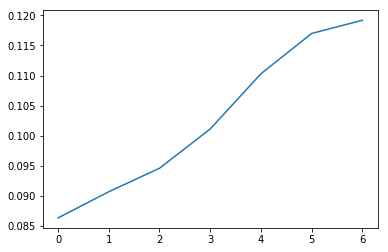

In [84]:
fig, ax = plt.subplots()
ax.plot(roc)
ax.axvline(k-1, color = 'black')
print(k)

In [78]:
d

[(2, 14.453905895626464),
 (3, 13.206722330088137),
 (4, 12.009577075331766),
 (5, 10.873993958161034),
 (6, 9.77460343122789),
 (7, 8.696556908556573),
 (8, 7.679039395421721),
 (9, 6.763675950365539)]

In [82]:
kn.knee

In [81]:
kn = KneeLocator(range(len(d)), list(d.values()), curve='convex', direction='decreasing')

C:\Users\Gimli\Anaconda3\lib\site-packages\kneed\knee_locator.py:188: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


In [85]:
find_k(roc)

C:\Users\Gimli\Anaconda3\lib\site-packages\kneed\knee_locator.py:134: RuntimeWarning: No local maxima found in the difference curve
The line is probably not polynomial, try plotting
the difference curve with plt.plot(knee.x_difference, knee.y_difference)
Also check that you aren't mistakenly setting the curve argument
  RuntimeWarning,


8

__Un-Lemmatize Labels__

In [17]:
def labels_unlem_create(df, labels, t):
    
    stemmer = PorterStemmer()
    
    # tfidf without lemitization
    tfidf = TfidfVectorizer(stop_words = stopwords.words('english'))
    m_norm = tfidf.fit_transform(df['text'])
    words = tfidf.get_feature_names()

    # dataframe that records words and their lemitized versions
    aux = pd.DataFrame(words, columns =['word'] )
    aux['word_stemmed'] = aux['word'].apply(lambda x : stemmer.stem(x))
    
    # count the number of words in the corpus 
    vec = sklearn.feature_extraction.text.CountVectorizer().fit(df['text'])
    bag_of_words = vec.transform(df['text'])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = pd.DataFrame(words_freq)
    words_freq.columns = ['word', 'num']
    
    # merge with aux and sort such that when take first value, will be most frequent word in corpus
    aux = pd.merge(aux, words_freq, on = 'word', how = 'left')
    aux = aux.sort_values(['word_stemmed', 'num'], ascending = False)
    
    if t == 'flat':
        # loop through returned labels and grab the first instance of the un-lemmatized word (just any version will do)
        labels_unlem = dict()
        for i in labels.keys():
            labels_unlem[i] = []
            for j in labels[i]:
                if len(aux[aux.word_stemmed == j]) == 0:
                    labels_unlem[i].append(j)
                    continue
                labels_unlem[i].append(aux[aux.word_stemmed == j].word.values[0])
            
    if t == 'sub': 
        labels_unlem = dict()
        for i in labels.keys():
            labels_unlem[i] = []
            ct = 0
            for j in labels[i]:
                labels_unlem[i].append([])
                for k in j:
                    if len(aux[aux.word_stemmed == k]) == 0:
                        labels_unlem[i][ct].append(k)
                        continue
                    labels_unlem[i][ct].append(aux[aux.word_stemmed == k].word.values[0])
                ct += 1
            
    return labels_unlem

__Sort Labels based on Silhouette Scores of Clusters__

In [18]:
def label_sort(labels, max_score):
    max_score = sorted(max_score.items(), key=operator.itemgetter(1), reverse = True)
    
    labels_sorted = dict()
    for i in max_score:
        labels_sorted[i[0]] = labels[i[0]]
        
    return labels_sorted

### Hierarchy: Sub-Clusters

__Linkage Matrix: Understand Node Linkages__

In [19]:
def linkage_df(linkage_matrix, frameh):
    # in linkage matrix, indicate the aggregated node for each node pair
    links = pd.DataFrame(linkage_matrix) # using euclidean 
    links.columns = ['source1', 'source2', 'd', 'n']

    links['target'] = 0
    n = len(frameh)-1
    for i, row in links.iterrows():
        n += 1
        links.at[i,'target'] = n
        
    return links

In [20]:
# flatten irregular nested lists
def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el

__Find Documents at Various Sub-Clusters__

In [21]:
def merge_docs(merge, source):
    merge = pd.merge(merge, merge[['target', 'docs']], left_on = source, right_on = 'target',  how = 'left')
    merge.docs_x = np.where(merge.docs_x.isnull(), '', merge.docs_x)
    merge.docs_y = np.where(merge.docs_y.isnull(), '', merge.docs_y)
    merge['docs'] = merge[['docs_x', 'docs_y']].values.tolist()
    merge = merge.drop(columns = ['docs_x', 'docs_y'])
    #merge.docs = merge.docs.apply(np.ravel)
    merge = merge.rename(columns = {'target_x':'target'})
    merge.docs = list(merge.docs.apply(lambda row: flatten(row)))
    merge.docs = merge.docs.apply(lambda row: [i for i in row if i != ''])

    return merge

In [22]:
def assign_docs(frameh, links):
    # initial merge between frame ids and source1/source2
    merge = pd.merge(links, frameh[['ids']], left_on = 'source1', right_index = True, how = 'left')
    merge = pd.merge(merge, frameh[['ids']], left_on = 'source2', right_index = True, how = 'left')
    # create single docs list column 
    merge = merge.rename(columns = {'ids_x':'docs1', 'ids_y':'docs2'})
    merge.docs2 = np.where(merge.docs2.isnull(), '', merge.docs2)
    merge.docs1 = np.where(merge.docs1.isnull(), '', merge.docs1)
    merge['docs']= merge[['docs1', 'docs2']].values.tolist()
    merge = merge.drop(columns = ['docs1', 'docs2'])
    # flattern docs list column
    merge.docs = merge.docs.apply(lambda row: [i for i in row if i != ''])
    merge['len'] = merge.docs.apply(lambda row: len(set(row)))

    # loop until have one id per document at node (n)
    while int(merge[merge.target == merge.target.max()].len) != int(merge[merge.target == merge.target.max()].n): 
        print(merge[merge.target == merge.target.max()].len)
        merge = merge_docs(merge, 'source1')
        merge = merge_docs(merge, 'source2')
        merge['len'] = merge.docs.apply(lambda row: len(set(row)))
        
        merge = merge.drop(columns = ['target_y'])

    merge.docs = merge.docs.apply(lambda row: set(row))
    
    return merge 

__Assign Graph Attributes: Docs__

In [23]:
def attributes(G, merge, frameh, links):
    # add docs to each target node so know which docs exist at each target 
    for i in list(merge.target.unique()):
        G.nodes[i]['docs'] = merge[merge.target == i].docs.values[0]

    # add docs to origianl nodes as well 
    ogdocs = pd.merge(links, frameh[['ids']], left_on = 'source1', right_index = True, how = 'left')
    ogdocs = pd.merge(ogdocs, frameh[['ids']], left_on = 'source2', right_index = True, how = 'left')
    for i in range(len(frameh)):
        if len(ogdocs[ogdocs.source1 == i].ids_x) != 0:
            G.nodes[i]['docs'] = ogdocs[ogdocs.source1 == i].ids_x.values[0]
        if len(ogdocs[ogdocs.source2 == i].ids_y) != 0:
            G.nodes[i]['docs'] = ogdocs[ogdocs.source2 == i].ids_y.values[0]
            
    return G

__Mark Top Level Clusters__

In [24]:
def top_cluster(G, frameh):
    # find top level clusters and mark as such - determined by fcluster above 
    nx.set_node_attributes(G, 0, 'cluster')
    for c in list(frameh.cluster.unique()):
        try:
            c_ids = set(frameh[frameh.cluster == c].ids.unique())
            node = [x for x,y in G.nodes(data=True) if y['docs']==c_ids][0] # equals ALL of these ids 
        except:
            c_ids = frameh[frameh.cluster == c].ids.unique()
            node = [x for x,y in G.nodes(data=True) if y['docs']==c_ids][0]
        G.nodes[node]['cluster'] = c
        
    return G 

__Labels for all Sub Clusters__

In [25]:
def sub_labels(links, m, frameh):
    labels_sub = []
    for i in list(range(links.target.max())):
        if i < len(frameh):
            cluster1 = list(frameh[frameh.ids == list(G.nodes[i].values())[0]].index.unique())
        else:
            cluster1 = list(frameh[frameh.ids.isin(list(list(G.nodes[i].values())[0]))].index.unique())
        # find documents cluster
        m1 = m[cluster1,:]
        # take mean vector among all documents
        m1 = m1.mean(axis = 0)

        # max values in mean vector: labels
        lst = []
        for i in np.argsort(np.asarray(m1)[0])[::-1][:3]:
            lst.append(feature_names[i])

        labels_sub.append(lst)
    
    return labels_sub        

__Create Hierarchy Graph__

In [26]:
def create_graph(links, merge, frameh):
    # add nodes
    G = nx.DiGraph()
    G.add_nodes_from(links.source1)
    G.add_nodes_from(links.source2)
    G.add_nodes_from(links.target)

    # add edges
    subset = links[['source1', 'target']]
    G.add_edges_from([tuple(x) for x in subset.values])
    subset = links[['source2', 'target']]
    G.add_edges_from([tuple(x) for x in subset.values])
    
    # add attributes
    G = attributes(G, merge, frameh, links)
    
    # mark top clusters: attributes
    G = top_cluster(G, frameh)
    
    return G 

In [27]:
def create_hierarchy(linkage_matrix, frameh):
    
    links = linkage_df(linkage_matrix, frameh)
    merge = assign_docs(frameh, links)
    G = create_graph(links, merge, frameh)
                     
    return G, links

__Labels for all Sub Clusters__

In [28]:
def sub_labels(links, m, frameh, G, feature_names):
    labels_sub = []
    for i in list(range(links.target.max())):
        if i < len(frameh):
            cluster1 = list(frameh[frameh.ids == list(G.nodes[i].values())[0]].index.unique())
        else:
            cluster1 = list(frameh[frameh.ids.isin(list(list(G.nodes[i].values())[0]))].index.unique())
        # find documents cluster
        m1 = m[cluster1,:]
        # take mean vector among all documents
        m1 = m1.mean(axis = 0)

        # max values in mean vector: labels
        lst = []
        for i in np.argsort(np.asarray(m1)[0])[::-1][:3]:
            lst.append(feature_names[i])

        labels_sub.append(lst)
    
    return labels_sub        

In [29]:
# get labels for subclusters 1 layer down from top flat clusters
def labels_layerdown(G, frameh, labels_sub):
    # identify topnodes 
    topnodes = []
    for c in list(frameh.cluster.unique()):
        topnodes.append([x for x,y in G.nodes(data=True) if y['cluster']==c][0])
        
    # find subcluster labels: 1 level down from topnodes 
    labels1 = dict()
    for i in range(len(topnodes)):
        sub = list(G.predecessors(topnodes[i]))
        labels1[i] = [labels_sub[int(j)] for j in sub]
        
    return labels1

__Main Hiearchy Function: Get Labels of all sub-clusters 1 down from top__

In [30]:
def hierarchy_main(linkage_matrix, frameh, tfidf_unreduced, df_subset, feature_names):
    G, links = create_hierarchy(linkage_matrix, frameh)
    labels_sub = sub_labels(links, tfidf_unreduced, frameh, G, feature_names)
    labels1 = labels_layerdown(G, frameh, labels_sub)
    labels1 = labels_unlem_create(df_subset, labels1, t = 'sub')
    
    return labels1 

In [31]:
# dendogram with manually drawn in cut line for tin  
#fig, ax = plt.subplots(figsize=(15, 20))
#ax = dendrogram(linkage_matrix, orientation="right", labels = frameh.ids.unique())
#plt.axvline(1.69)

# Main Function

In [76]:
d = main(True)

retail


In [35]:
def main(reduce, hierarchy = False, hsearch = False):
    
    # read in data
    df = pd.read_pickle('reuters_processed')
    
    # set of topics
    topics = list(df.categories)
    topics = [item for sublist in topics for item in sublist]
    topics = list(set(topics))
    
    distortion_dict = dict()
    silhouette_dict = dict()
    k_dict = dict()
    labels_dict = dict()
    dist_dict = dict()
    cluster1 = list()
    
    df_final = pd.DataFrame()
    
    if hierarchy: 
        topics = [hsearch]
    
    for search in topics:
        
        if search == 'earn' or search == 'acq': # too big to deal with
            continue
        
        gc.collect()

        df_subset = df[df.categories.map(set([search]).issubset)] 
        df_subset = df_subset.reset_index()
        
        if len(df_subset) < 5:
            cluster1.append(search)
            continue
            
        print(search)
        
        # TF-IDF matrix
        tfidf, feature_names = tf_idf(df_subset)

        # remove search from tf-idf matrix
        tfidf, feature_names = remove_search(tfidf, feature_names, search)

        # PCA dimensionality reduction
        if reduce:
            tfidf_unreduced = tfidf.copy()
            tfidf = pca_reduce(tfidf)
                    
        # distances 
        dist, dist_flat = dist_calculate(tfidf, reduce)
                
        # linkage matrix
        linkage_matrix = linkage_calculate(dist_flat)
        
        # find K 
        if reduce: 
            #return linkage_matrix, tfidf, tfidf_unreduced, dist, df_subset, feature_names, search
            if len(df_subset) < 7: # else searching for a k is useless. only reasonable number is 2. 
                k = 2
            else:
                # use non-reduced tfidf to find labels. reduced for everything else. 
                distortion_lst, silhouette_lst = distortion_silhouette(linkage_matrix, tfidf, tfidf_unreduced, dist, df_subset,
                                                                       feature_names, search)
                
                roc = distortion_roc(distortion_lst)
                k = find_k(roc)
            
            # final flat clusters
            frameh, labels, centroid = find_clusters(k, linkage_matrix, tfidf, tfidf_unreduced, 
                                                     df_subset, feature_names, search)
            
            if frameh.cluster.nunique() == 1:   
                cluster1.append(search)
                continue
                
            distortion, distortion_avg = distortion_calculate(tfidf, centroid, frameh)
            silhouette_cluster, silhouette_avg = silhouette_avg_calculate(frameh, dist)
            
        else:
            # pass tfidf in for both reduced and unreduced arguments
            distortion_lst, silhouette_lst = distortion_silhouette(linkage_matrix, tfidf, tfidf, dist, df_subset, 
                                                                   feature_names, search)
            roc = distortion_roc(distortion_lst)
            k = find_k(roc)

            # final flat clusters
            frameh, labels, centroid = find_clusters(k, linkage_matrix, tfidf, tfidf, 
                                                     df_subset, feature_names, search)
            if frameh.cluster.nunique() == 1:   
                cluster1.append(search)
                continue
                
            distortion, distortion_avg = distortion_calculate(tfidf, centroid, frameh)
            silhouette_cluster, silhouette_avg = silhouette_avg_calculate(frameh, dist)
            
        # un-lemmatize labels
        labels = labels_unlem_create(df_subset, labels, t = 'flat')
        
        # sort labels based on cluster silhouette score
        labels = label_sort(labels, silhouette_cluster)

        # dictionary record 
        distortion_dict[search] = distortion_avg
        silhouette_dict[search] = silhouette_avg
        k_dict[search] = k
        labels_dict[search] = labels
        dist_dict[search] = dist
        
        frameh['search'] = search
        df_final = df_final.append(frameh)
        
        if hierarchy: 
            labels1 = hierarchy_main(linkage_matrix, frameh, tfidf_unreduced, df_subset, feature_names)
            return labels1

    return distortion_dict, silhouette_dict, k_dict, labels_dict, df_final, dist_dict, cluster1

In [36]:
#labels1 = main(reduce = True, hierarchy = True, hsearch = 'tin')

In [37]:
distortion_dict, silhouette_dict, k_dict, labels_dict, df_final, dist_dict, cluster1 = main(reduce = True)

wheat
barley
naphtha
crude
alum


C:\Users\Gimli\Anaconda3\lib\site-packages\kneed\knee_locator.py:134: RuntimeWarning: No local maxima found in the difference curve
The line is probably not polynomial, try plotting
the difference curve with plt.plot(knee.x_difference, knee.y_difference)
Also check that you aren't mistakenly setting the curve argument
  RuntimeWarning,


money-supply
bop
housing
gnp
propane
palm-oil
ipi
sorghum
coconut-oil
tea
retail
jobs
sugar
l-cattle
rice
soy-meal
oat
trade
lei
veg-oil
livestock
dlr
instal-debt
platinum
pet-chem
ship
income
potato
groundnut
strategic-metal
yen
cpi
cocoa
zinc
sun-oil
reserves
interest
rapeseed
oilseed
hog
money-fx
orange
corn
rape-oil
cotton
coconut
heat
jet
wpi
lumber
copper
nickel
fuel
coffee
tin
soy-oil
gold
gas
rubber
meal-feed
nat-gas
silver
carcass
grain
sunseed
soybean
iron-steel
lead
dmk


In [39]:
with open('hierarchial', "wb") as f:
    pickle.dump(df_final, f)
    pickle.dump(labels_dict, f)
    pickle.dump(k_dict, f)
    pickle.dump(distortion_dict, f)
    pickle.dump(silhouette_dict, f)

In [38]:
k_dict

{'alum': 9,
 'barley': 5,
 'bop': 3,
 'carcass': 4,
 'cocoa': 3,
 'coconut': 2,
 'coconut-oil': 2,
 'coffee': 3,
 'copper': 3,
 'corn': 4,
 'cotton': 3,
 'cpi': 3,
 'crude': 6,
 'dlr': 6,
 'dmk': 4,
 'fuel': 3,
 'gas': 3,
 'gnp': 5,
 'gold': 5,
 'grain': 4,
 'groundnut': 2,
 'heat': 6,
 'hog': 7,
 'housing': 3,
 'income': 5,
 'instal-debt': 2,
 'interest': 4,
 'ipi': 9,
 'iron-steel': 3,
 'jet': 2,
 'jobs': 5,
 'l-cattle': 2,
 'lead': 4,
 'lei': 4,
 'livestock': 4,
 'lumber': 3,
 'meal-feed': 3,
 'money-fx': 4,
 'money-supply': 5,
 'naphtha': 2,
 'nat-gas': 3,
 'nickel': 2,
 'oat': 4,
 'oilseed': 3,
 'orange': 4,
 'palm-oil': 6,
 'pet-chem': 3,
 'platinum': 3,
 'potato': 2,
 'propane': 2,
 'rape-oil': 2,
 'rapeseed': 5,
 'reserves': 3,
 'retail': 8,
 'rice': 8,
 'rubber': 6,
 'ship': 5,
 'silver': 6,
 'sorghum': 5,
 'soy-meal': 4,
 'soy-oil': 8,
 'soybean': 6,
 'strategic-metal': 3,
 'sugar': 6,
 'sun-oil': 2,
 'sunseed': 5,
 'tea': 4,
 'tin': 3,
 'trade': 5,
 'veg-oil': 4,
 'wheat': 6

In [40]:
labels_dict

{'alum': {1: ['credit', 'azpurua', 'financing'],
  2: ['prices', 'lb', 'cents'],
  3: ['alcan', 'close', 'smelter'],
  4: ['british', 'vessel', 'orinoco'],
  5: ['suralco', 'billiton', 'bauxite'],
  6: ['reynolds', 'restart', 'metal'],
  7: ['ipai', 'ave', 'daily'],
  8: ['lme', 'contract', 'grade'],
  9: ['aluminium', 'plant', 'smelter']},
 'barley': {1: ['ecus', 'licences', 'ec'],
  2: ['bonus', 'ccc', 'accepted'],
  3: ['wheat', 'uk', 'export'],
  4: ['reserve', 'v', 'iv'],
  5: ['crops', 'usda', 'acres']},
 'bop': {1: ['dollars', 'deficit', 'surplus'],
  2: ['lire', 'italy', 'showed'],
  3: ['surplus', 'current', 'deficit']},
 'carcass': {1: ['plant', 'union', 'iowa'],
  2: ['japan', 'beef', 'imports'],
  3: ['ec', 'meat', 'us'],
  4: ['meat', 'pork', 'poultry']},
 'cocoa': {1: ['buffer', 'stock', 'delegates'],
  2: ['season', 'purchases', 'board'],
  3: ['official', 'icco', 'stock']},
 'coconut': {1: ['products', 'exports', 'ec'],
  2: ['agency', 'military', 'administrator']},
 'c

In [ ]:
search = 'income'
# TSNE
embed = TSNE(n_components=2).fit_transform(dist_dict[search], 'precomputed')
xs, ys = embed[:, 0], embed[:, 1]

# DataFrame to Plot 
clusters = df_final[df_final.search == search].cluster.tolist()
df_vis = pd.DataFrame(dict(x = xs, y = ys, cluster = clusters))
df_vis.cluster = df_vis.cluster  # want clusters to start at 0 

fig, ax = plt.subplots(figsize=(17, 9)) 

groups = df_vis.groupby('cluster')

for name, group in groups:
    ax.scatter(group.x, group.y, label = labels_dict[search][name])
    ax.legend()

In [41]:
pd.DataFrame(list(distortion_dict.values())).describe()

,0
count,74.000000
mean,0.517065
std,0.129192
min,0.177927
25%,0.450319
50%,0.531072
75%,0.623683
max,0.706323


In [42]:
pd.DataFrame(list(silhouette_dict.values())).describe()

,0
count,74.000000
mean,0.367271
std,0.159916
min,0.062415
25%,0.270007
50%,0.371043
75%,0.466095
max,0.776284


In [43]:
sorted(distortion_dict.items(), key=operator.itemgetter(1))

[('hog', 0.17792687763780435),
 ('heat', 0.24897209150898678),
 ('income', 0.25270915632234053),
 ('dmk', 0.25882163770657574),
 ('instal-debt', 0.2808990712154988),
 ('potato', 0.28145799043823966),
 ('sunseed', 0.3052471127967343),
 ('retail', 0.3071615758168687),
 ('lei', 0.33203596770389765),
 ('soy-oil', 0.33729714390474336),
 ('rapeseed', 0.3432886106757653),
 ('jet', 0.3628153169808612),
 ('tea', 0.3735848572570473),
 ('oat', 0.4088288411781308),
 ('housing', 0.4329018344079031),
 ('ipi', 0.4400821126423167),
 ('coconut', 0.4417627897843391),
 ('propane', 0.4424060872205235),
 ('fuel', 0.44945781299699783),
 ('silver', 0.452902322883995),
 ('lead', 0.4533011524621149),
 ('rape-oil', 0.4605892522961108),
 ('orange', 0.4701828488713825),
 ('sorghum', 0.4710236745820891),
 ('palm-oil', 0.47189036535614787),
 ('alum', 0.4789406619646696),
 ('naphtha', 0.47978793438321365),
 ('platinum', 0.481967996811276),
 ('lumber', 0.48667637530275143),
 ('zinc', 0.4947527034770406),
 ('coconut-o

In [44]:
sorted(silhouette_dict.items(), key=operator.itemgetter(1))

[('naphtha', 0.062414707405202025),
 ('sun-oil', 0.06576980745592892),
 ('cpi', 0.10092874581465683),
 ('trade', 0.111975195811744),
 ('gnp', 0.11256804561594994),
 ('propane', 0.11597138956373176),
 ('l-cattle', 0.11744798582507145),
 ('groundnut', 0.12168392776677675),
 ('crude', 0.1413425826985756),
 ('nat-gas', 0.14211305518807846),
 ('grain', 0.1827783202342523),
 ('carcass', 0.18611797200796704),
 ('ship', 0.19960308733158424),
 ('veg-oil', 0.20094007521821838),
 ('money-fx', 0.21327899077363202),
 ('gold', 0.21340759658894526),
 ('wpi', 0.24013855377377671),
 ('dlr', 0.24350234581666197),
 ('sugar', 0.2684972692807997),
 ('jobs', 0.2745378102567951),
 ('tin', 0.27455293792208085),
 ('copper', 0.2760744277334159),
 ('iron-steel', 0.2808845555022474),
 ('wheat', 0.2830587148020233),
 ('soy-meal', 0.28570830704294464),
 ('corn', 0.29641167249146105),
 ('soybean', 0.3188206374627352),
 ('reserves', 0.33391305947807676),
 ('rubber', 0.34217657606262675),
 ('barley', 0.346923665540751

In [ ]:
### TO DO: hierarchies 